## Finding the NESZ
we assume a spherical earth system
1. define an incidence angle / range vector
2. orient the radar
2. choose the doppler bandwidth as the 3-dB beamwidth on ground at the scene center incidence angle. use a linear time doppler relation based on the equivalent speed as seen by the target on ground (quadratic range approximation)
3. create the range-doppler meshgrid
4. for every point in range doppler find a point on earth surface in GCS x,y,z
5. GCS to lcs
6. lcs to theta-phi
7. get the antenna pattern
8. posp wighting of the pattern
9. integration
10. core snr
11. multiply core snr with the system table values.

## 1. Doppler bandwidth

In [1]:
# broadside incidence angle
theta_i = 30
# antenna
la = 2  # m
wa = .3  # m
h = 500e3
wavel = 299792458.0 / 10e9

In [2]:
from spherical_earth_geometry_radar import *
import numpy as np

# create geometry
radarGeo = RadarGeometry()
# looking angle
beta = incidence_angle_to_looking_angle(theta_i * np.pi / 180)
radarGeo.set_rotation(beta, 0, 0)
# inital position
radarGeo.set_initial_position(0, 0, h)
# speed
v_s = radarGeo.orbital_speed()
radarGeo.set_speed(v_s)

print("orbital speed = ", v_s)
print("looking angle = ", beta * 180 / np.pi)

orbital speed =  [7612.68398988]
looking angle =  27.620636562903183


In [3]:
Bd = nominal_doppler_bandwidth(la, theta_i*np.pi/180, wavel, v_s, h)
print("Nominal Doppler Bandwidth = ", Bd)
wavel

Nominal Doppler Bandwidth =  [7613.3079469]


0.0299792458

## 2. incidence angle - Doppler axes

In [4]:
# example incidence angle extremes
theta_i_min = theta_i * np.pi / 180 - wavel / (2 * wa)
theta_i_max = theta_i * np.pi / 180 + wavel / (2 * wa)

incidence = np.linspace(theta_i_min, theta_i_max, 3)
doppler = np.linspace(-Bd / 2, Bd / 2, 5)


## 3. Meshgridding and antenna pattern coordinates retrieval

In [5]:
# incidence doppler
I, D = np.meshgrid(incidence, doppler)
# incidence azimuth stationary time
I, A, Tk = mesh_doppler_to_azimuth(I, D, wavel, v_s, h)

In [6]:
print(I * 180 / np.pi)

[[27.1371929 30.        32.8628071]
 [27.1371929 30.        32.8628071]
 [27.1371929 30.        32.8628071]
 [27.1371929 30.        32.8628071]
 [27.1371929 30.        32.8628071]]


In [7]:
print(D)

[[-3806.65397345 -3806.65397345 -3806.65397345]
 [-1903.32698673 -1903.32698673 -1903.32698673]
 [    0.             0.             0.        ]
 [ 1903.32698673  1903.32698673  1903.32698673]
 [ 3806.65397345  3806.65397345  3806.65397345]]


In [8]:
print(A)

[[ 4171.91838233  4276.34532925  4396.04382177]
 [ 2085.91164907  2138.12391559  2197.97178078]
 [   -0.            -0.            -0.        ]
 [-2085.91164907 -2138.12391559 -2197.97178078]
 [-4171.91838233 -4276.34532925 -4396.04382177]]


In [9]:
print(Tk)

[[ 0.59143495  0.60634793  0.6234518 ]
 [ 0.29571073  0.30316705  0.31171879]
 [-0.         -0.         -0.        ]
 [-0.29571073 -0.30316705 -0.31171879]
 [-0.59143495 -0.60634793 -0.6234518 ]]


In [10]:
# GCS
X, Y, Z = mesh_incidence_azimuth_to_gcs(I, A, wavel, v_s, h)


In [11]:
print(X)

[[ 4171.91808377  4276.34500759  4396.04347218]
 [ 2085.91161175  2138.12387538  2197.97173708]
 [   -0.            -0.            -0.        ]
 [-2085.91161175 -2138.12387538 -2197.97173708]
 [-4171.91808377 -4276.34500759 -4396.04347218]]


In [12]:
print(Y)

[[-235394.12871196 -264497.10438039 -295082.46473317]
 [-235394.12871196 -264497.10438039 -295082.46473317]
 [-235394.12871196 -264497.10438039 -295082.46473317]
 [-235394.12871196 -264497.10438039 -295082.46473317]
 [-235394.12871196 -264497.10438039 -295082.46473317]]


In [13]:
print(Z)

[[-4351.49397523 -5494.20747669 -6838.78159826]
 [-4350.4687991  -5493.13014268 -6837.64286868]
 [-4350.12709447 -5492.77105317 -6837.26331523]
 [-4350.4687991  -5493.13014268 -6837.64286868]
 [-4351.49397523 -5494.20747669 -6838.78159826]]


In [14]:
re = 6371e3
R0_mesh = re * (np.sqrt(cos(I) ** 2 + 2 * h / re + h ** 2 / re ** 2) - cos(I))
# cosine of earth-centric elevation angle of azimuth circle parallel to the orbital plane on the sphere
cos_theta_e = (re + R0_mesh * cos(I)) / (re + h)

In [15]:
print(np.arccos(cos_theta_e) * 180 / np.pi)

[[2.11743221 2.37936344 2.65469009]
 [2.11743221 2.37936344 2.65469009]
 [2.11743221 2.37936344 2.65469009]
 [2.11743221 2.37936344 2.65469009]
 [2.11743221 2.37936344 2.65469009]]


Text(0.5, 0, 'z [m]')

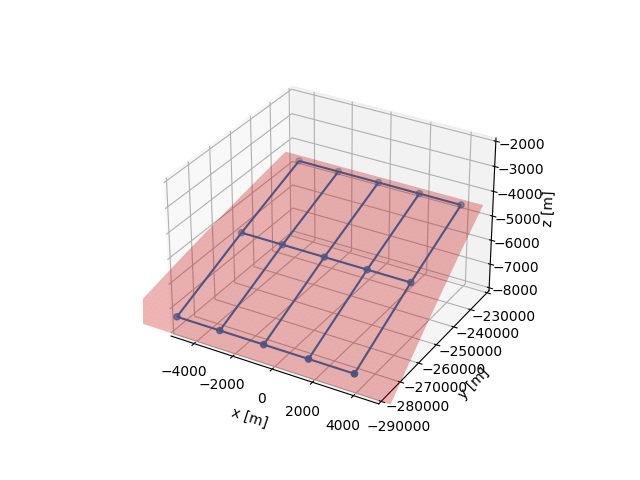

In [16]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.use('Qt5Agg')
%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X, Y, Z)
ax.set_xlim(-5000, 5000)
ax.set_ylim(-290e3, -230e3)
ax.set_zlim(-8e3, -2e3)

# draw sphere
u, v = np.mgrid[-2.5 * np.pi / 360:2.5 * np.pi / 360:2000j, 2.1 * np.pi / 180:2.7 * np.pi / 180:100j]
x = re * np.sin(u) * np.sin(v)
y = - re * np.cos(u) * np.sin(v)
z = re * np.cos(v) - re
ax.plot_surface(x, y, z, color="r", alpha=0.3)

ax.plot_wireframe(X, Y, Z)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

In [17]:
# LCS
Xl, Yl, Zl = mesh_gcs_to_lcs(X, Y, Z, radarGeo.Bc2s, radarGeo.S_0)
# LCS spherical
R, T, P = meshCart2sph(Xl, Yl, Zl)

In [18]:
print(R)

[[556595.21216734 570527.29921076 586496.8343676 ]
 [556582.55653333 570514.32446589 586483.49363085]
 [556578.33818096 570509.99974814 586479.04692144]
 [556582.55653333 570514.32446589 586483.49363085]
 [556595.21216734 570527.29921076 586496.8343676 ]]


In [19]:
print(T * 180 / np.pi)

[[2.63612865 0.42946029 2.62278089]
 [2.60973358 0.21472863 2.59635043]
 [2.60087587 0.         2.58748045]
 [2.60973358 0.21472863 2.59635043]
 [2.63612865 0.42946029 2.62278089]]


In [20]:
print(P * 180 / np.pi)

[[-8.06207178e+01 -8.92257209e-03  8.05725846e+01]
 [-8.52787482e+01 -4.46118428e-03  8.52543732e+01]
 [-9.00000000e+01 -9.00000000e+01  9.00000000e+01]
 [-9.47212518e+01 -1.79995539e+02  9.47456268e+01]
 [-9.93792822e+01 -1.79991077e+02  9.94274154e+01]]


In [37]:
np.round(P/(np.pi))* np.pi

array([[-0.        , -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ],
       [-3.14159265, -3.14159265,  3.14159265],
       [-3.14159265, -3.14159265,  3.14159265]])

## 3. Antenna pattern generation

In [21]:
from radartools.farField import UniformAperture

uniap = UniformAperture(la, wa, 10e9)
Gain = uniap.mesh_gain_pattern_theor(T, P) / uniap.max_gain()
Gain = np.where(np.isnan(Gain), 1, Gain)

C:\Users\smen851\PycharmProjects\design-baseline\radartools\farField.py:149: RuntimeWarning: invalid value encountered in divide
  f = sin(kx * self.L / 2) / (kx * self.L / 2) * sin(ky * self.W / 2) / (ky * self.W / 2) * self.L * self.W


In [22]:
print(10 * np.log10(Gain))

[[-7.10426782 -3.92323151 -7.06855041]
 [-4.09334407 -0.91228087 -4.0578904 ]
 [-3.18107217  0.         -3.14570641]
 [-4.09334407 -0.91228087 -4.0578904 ]
 [-7.10426782 -3.92323151 -7.06855041]]


## 4. Integrand definition and discrete integration

In [23]:
# the matched filter amplitude
H = 1 / (stationary_phase_amplitude_multiplier(I, Tk, wavel, v_s, h) * Gain)

In [24]:
print(H)

[[411.84309941 195.53328648 397.84334179]
 [205.89901368  97.75533939 198.91198434]
 [166.89065708  79.23505279 161.23061214]
 [205.89901368  97.75533939 198.91198434]
 [411.84309941 195.53328648 397.84334179]]


In [25]:
from scipy import integrate

w_range = integrate.simps(H ** 2, D, axis=0)
print(w_range)

[4.65737573e+08 1.04982295e+08 4.34641904e+08]


In [26]:
#[4.65737573e+08 1.04982295e+08 4.34641904e+08]

## 5. normalized SNR calculation

In [27]:
from design_functions import range_from_theta

# the core snr over ground range is then given by:
# Boltzman constant
k_boltz = 1.380649E-23  # J/K
# the sin of the incidence angle at each ground range point
sin_theta_i = sin(incidence)
# The range at each ground range point
r0 = re * (np.sqrt(cos(incidence) ** 2 + 2 * h / re + h ** 2 / re ** 2) - cos(incidence))
max_gain = uniap.max_gain()
print(max_gain)
c = 299792458
vg = v_s / (re + h) * re * cos_theta_e[0, :]
# the equation is then: (equivalent to the above, just simplified)
SNR_core = wavel ** 2 * max_gain ** 2 * c * Bd * vg / (128 * np.pi ** 3 * r0 ** 4 * k_boltz * sin_theta_i * w_range)

8389.183781074367


In [28]:
print(10 * np.log10(SNR_core))

[89.59832728 95.23943809 88.23346339]


In [29]:
print(r0)

[556578.33818095 570509.99974814 586479.04692143]


In [30]:
print(R0_mesh)
r, rg = range_from_theta(180 * incidence / np.pi, h)
print(rg)

[[556578.33818095 570509.99974814 586479.04692143]
 [556578.33818095 570509.99974814 586479.04692143]
 [556578.33818095 570509.99974814 586479.04692143]
 [556578.33818095 570509.99974814 586479.04692143]
 [556578.33818095 570509.99974814 586479.04692143]]
[235447.71915474 264573.14284872 295188.06945218]


(90.0, 99.0)

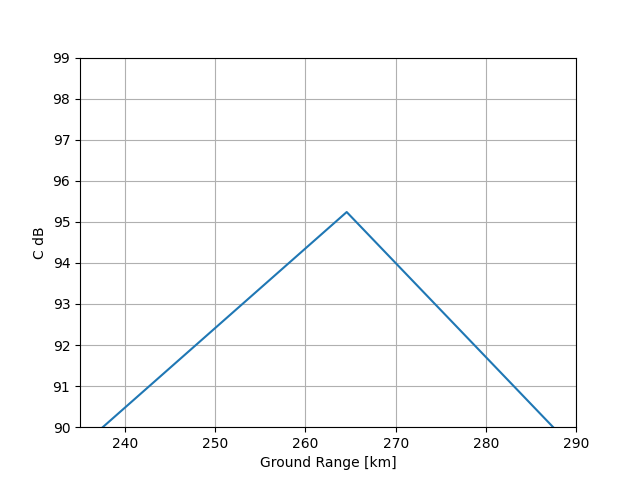

In [31]:
# plotting
fig, ax = plt.subplots(1)
ax.plot(rg / 1000, 10 * np.log10(SNR_core))
ax.set_xlabel('Ground Range [km]')
ax.set_ylabel('C dB')
ax.grid()
ax.set_xlim(235, 290)
ax.set_ylim(90, 99)

# As a single function

In [32]:
SNR_core1, daz = core_snr_spherical(radarGeo, uniap, incidence, wavel, v_s, h)

In [33]:
uniap.__dict__

{'W': 0.3,
 'L': 2,
 'freq': 10000000000.0,
 'c': 299792458,
 'k': 209.58450219516817,
 'inputPower': 1,
 'eta': 376.7303136686,
 'l_mesh': array([-1.        , -0.99700599, -0.99401198, -0.99101796, -0.98802395,
        -0.98502994, -0.98203593, -0.97904192, -0.9760479 , -0.97305389,
        -0.97005988, -0.96706587, -0.96407186, -0.96107784, -0.95808383,
        -0.95508982, -0.95209581, -0.9491018 , -0.94610778, -0.94311377,
        -0.94011976, -0.93712575, -0.93413174, -0.93113772, -0.92814371,
        -0.9251497 , -0.92215569, -0.91916168, -0.91616766, -0.91317365,
        -0.91017964, -0.90718563, -0.90419162, -0.9011976 , -0.89820359,
        -0.89520958, -0.89221557, -0.88922156, -0.88622754, -0.88323353,
        -0.88023952, -0.87724551, -0.8742515 , -0.87125749, -0.86826347,
        -0.86526946, -0.86227545, -0.85928144, -0.85628743, -0.85329341,
        -0.8502994 , -0.84730539, -0.84431138, -0.84131737, -0.83832335,
        -0.83532934, -0.83233533, -0.82934132, -0.82634731

In [34]:
print(10*np.log10(SNR_core1))
print(SNR_core)
print(SNR_core1)

[89.82955055 95.47066613 88.46463978]
[9.11659639e+08 3.34151803e+09 6.65803907e+08]
[9.61512767e+08 3.52424922e+09 7.02205098e+08]


In [35]:
print("[89.59834393 95.23945473 88.23348003]")

[89.59834393 95.23945473 88.23348003]


In [36]:
print(daz)

[0.92652133 0.92635505 0.92615939]
